<a href="https://colab.research.google.com/github/rasim321/A-Song-of-Text-and-Generators/blob/main/Got_Generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import re
!pip install transformers

     |████████████████████████████████| 2.3MB 7.7MB/s 
     |████████████████████████████████| 901kB 37.3MB/s 
     |████████████████████████████████| 3.3MB 47.3MB/s 


In [2]:
#Read the books
books =[]
for book in ['got1.txt', 'got2.txt', 'got3.txt', 'got4.txt', 'got5.txt']:
  book = "/content/" + book
  with open(book) as file:
    books.append(file.read())

#Clean the books of "\n" tags
books_cl = []
for book_text in books:
  books_cl.append(book_text.replace('\n', ' '))


We do not want to take the punctuation and stop words from the text corpus because we want our language model to learn the structure of the text. So those stay on. It is a good idea to clean the books of the content page and the general publisher text from the beginning of the book. 

Text(0.5, 1.0, 'Number of characters per book')

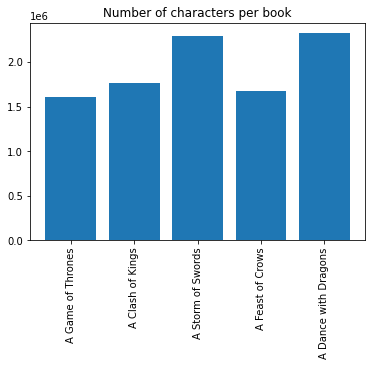

In [3]:
import matplotlib.pyplot as plt

bl_lens = [len(i) for i in books_cl]
bl_names = ['A Game of Thrones', "A Clash of Kings", "A Storm of Swords", "A Feast of Crows", "A Dance with Dragons"]

plt.bar(bl_names, bl_lens)
plt.xticks(rotation=90)
plt.title("Number of characters per book")


Text(0.5, 1.0, 'Number of words per book')

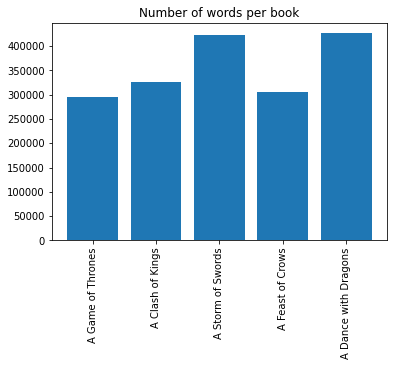

In [4]:
bl_words = []

for book in books_cl: 
  bl_words.append(len(book.split()))

plt.bar(bl_names, bl_words)
plt.xticks(rotation=90)
plt.title("Number of words per book")

The third and fifth books are the longest in the series, with the fifth book being slightly larger

In [5]:
from transformers import BertTokenizer, TFBertForSequenceClassification, BertConfig
from transformers import GPT2Tokenizer, TFGPT2LMHeadModel

gpt_tokenizer = GPT2Tokenizer.from_pretrained("distilgpt2")

In [10]:
# corpus = ''
# for book in books_cl:
#   corpus += book

book_1 = books_cl[0]
len(book_1.split())
#Let's check whether the corpus was built correctly
# assert len(corpus) == sum([len(i) for i in books_cl]), "something went wrong"

295970

In [11]:
corpus_tk = gpt_tokenizer.encode(book_1, max_length=300000, truncation=True)


In [14]:
import numpy as np
# corpus_tk_arr = np.array(corpus_tk)
# np.save('book_1_embeddings.npy', corpus_tk_arr)

In [16]:
# Split into blocks
training_chunks = []
block_size = 100

for i in range(0,len(corpus_tk),block_size):
        training_chunks.append(corpus_tk[i:i + block_size])

# Generate inputs and labels
inputs = []
labels = []
for ex in training_chunks:
    inputs.append(ex[:-1])
    labels.append(ex[1:])

print("inputs length:",len(inputs))
print("labels length:",len(labels))

inputs length: 3000
labels length: 3000


In [26]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.utils.layer_utils import count_params
AUTOTUNE = tf.data.experimental.AUTOTUNE

BATCH_SIZE = 12
TRAIN_SHUFFLE_BUFFER_SIZE = len(inputs)

# Create TF Dataset
train_data = tf.data.Dataset.from_tensor_slices((inputs, labels))

#############
# Train data
#############
train_data = train_data.shuffle(buffer_size=TRAIN_SHUFFLE_BUFFER_SIZE)
train_data = train_data.batch(BATCH_SIZE, drop_remainder=True)
train_data = train_data.prefetch(buffer_size=AUTOTUNE)

print("train_data",train_data)

train_data <PrefetchDataset shapes: ((12, 99), (12, 99)), types: (tf.int32, tf.int32)>


In [27]:
K.clear_session()

# Build the model
model = TFGPT2LMHeadModel.from_pretrained("distilgpt2")


All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at distilgpt2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


In [29]:
import time 
learning_rate = 3e-5 
epsilon=1e-08
clipnorm=1.0
epochs = 30


# Print the model architecture
print(model.summary())

# Optimizer
optimizer = keras.optimizers.Adam(learning_rate=learning_rate, epsilon=epsilon, clipnorm=clipnorm)
# Loss
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = keras.metrics.SparseCategoricalAccuracy('accuracy')

# Compile
model.compile(loss=[loss, *[None] * model.config.n_layer],
                  optimizer=optimizer,
                  metrics=[metric])

# Train model
start_time = time.time()
training_results = model.fit(
        train_data, # train_data.take(1000) for testing
        epochs=epochs, 
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)


Model: "tfgp_t2lm_head_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
transformer (TFGPT2MainLayer multiple                  81912576  
Total params: 81,912,576
Trainable params: 81,912,576
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expe

In [30]:
model.save_weights('.my_checkpoint')

In [31]:
model.save('my_model')

INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets


In [33]:
input_text = "Sansa frowned"

# Tokenize Input
input_ids = gpt_tokenizer.encode(input_text, return_tensors='tf')
print("input_ids",input_ids)

# Generate outout
outputs = model.generate(
    input_ids, 
    do_sample=True, 
    max_length=250, 
    top_p=0.80, 
    top_k=0
)

print("Generated text:")
display(gpt_tokenizer.decode(outputs[0], skip_special_tokens=True))

Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


input_ids tf.Tensor([[   50   504    64 32198]], shape=(1, 4), dtype=int32)
Generated text:


'Sansa frowned. “We will hire men who understand the man’s needs.”  “They will,” Tyrion said. He turned back to the other men. “You have no time for this, lady. You have no place here.”  “It is my place, m’lord,” the dwarf said. “Your place here will be your own.”  “Your place is here,” Tyrion said.  “You are not alone,” Catelyn reminded him. “Nor are we alone. You must not forget who you are, nor do you place your trust. You must not forget who you are.”  “Your place is yours,” Varys said.  “You are not alone,” the dwarf said. “A knight must be brave, yes. Your place is yours. A knight must be brave.”  “A knight must be brave, yes,” the dwarf said. “Not alone,” she told him. “You must not forget who you are.”  “Do'